In [1]:
import pandas as pd
import seaborn as sns
from datascience import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\Raeds\AppData\Local\Temp\ipykernel_2884\3733983129.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medals_only["Medal_Score"] = medals_only["Medal"].map(medal_weights)


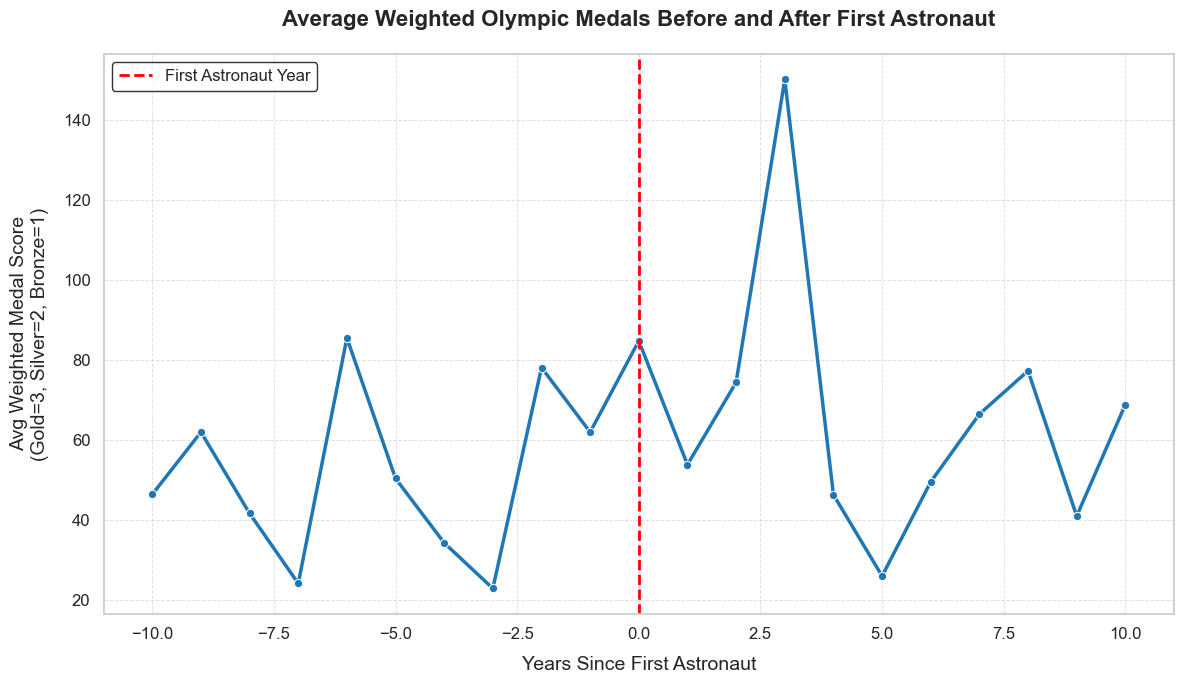

In [2]:
Social_df = pd.read_csv("Social_Science.csv")
# Load the social science dataset
social_df = pd.read_csv("Social_Science.csv")

# Get the first astronaut year per country
first_astronaut_year = (
    social_df.groupby("Profile.Nationality")["Mission.Year"]
    .min()
    .reset_index()
    .rename(columns={"Profile.Nationality": "Country", "Mission.Year": "First_Astronaut_Year"})
)
medals_df = pd.read_csv("athlete_events.csv")

# Keep only rows with medals
medals_only = medals_df.dropna(subset=["Medal"])

# Aggregate medals by country (Team) and Year
medals_by_country_year = (
    medals_only.groupby(["Team", "Year"])["Medal"]
    .count()
    .reset_index()
    .rename(columns={"Medal": "Medal_Count"})
)

merged = medals_by_country_year.merge(
    first_astronaut_year,
    left_on="Team",   # Olympic dataset country names
    right_on="Country",  # Astronaut dataset country names
    how="inner"
)

# Calculate years since first astronaut
merged["Years_Since_Astronaut"] = merged["Year"] - merged["First_Astronaut_Year"]

# Focus on ±10 year window
event_window = merged[
    (merged["Years_Since_Astronaut"] >= -10) &
    (merged["Years_Since_Astronaut"] <= 10)
]

# Define medal weights
medal_weights = {"Gold": 3, "Silver": 2, "Bronze": 1}

# Apply weights
medals_only["Medal_Score"] = medals_only["Medal"].map(medal_weights)

# Aggregate weighted medal scores by country and year
medals_weighted = (
    medals_only.groupby(["Team", "Year"])["Medal_Score"]
    .sum()
    .reset_index()
    .rename(columns={"Medal_Score": "Weighted_Medal_Score"})
)


merged = medals_weighted.merge(
    first_astronaut_year,
    left_on="Team",
    right_on="Country",
    how="inner"
)

merged["Years_Since_Astronaut"] = merged["Year"] - merged["First_Astronaut_Year"]

event_window = merged[
    (merged["Years_Since_Astronaut"] >= -10) &
    (merged["Years_Since_Astronaut"] <= 10)
]



# Set a nicer style
sns.set_theme(style="whitegrid")

# Compute average weighted medals around astronaut year
avg_medals = (
    event_window.groupby("Years_Since_Astronaut")["Weighted_Medal_Score"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12,7))
sns.lineplot(
    data=avg_medals,
    x="Years_Since_Astronaut",
    y="Weighted_Medal_Score",
    marker="o",
    linewidth=2.5,
    color="#1f77b4"  # clean blue tone
)

# Add vertical line at astronaut year
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="First Astronaut Year")

# Title and labels with better formatting
plt.title(
    "Average Weighted Olympic Medals Before and After First Astronaut",
    fontsize=16,
    fontweight="bold",
    pad=20
)
plt.xlabel("Years Since First Astronaut", fontsize=14, labelpad=10)
plt.ylabel("Avg Weighted Medal Score\n(Gold=3, Silver=2, Bronze=1)", fontsize=14, labelpad=10)

# Add subtle background grid
plt.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.6)

# Tweak ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Legend styling
plt.legend(frameon=True, fontsize=12, loc="upper left", edgecolor="black")

# Tight layout
plt.tight_layout()
plt.show()



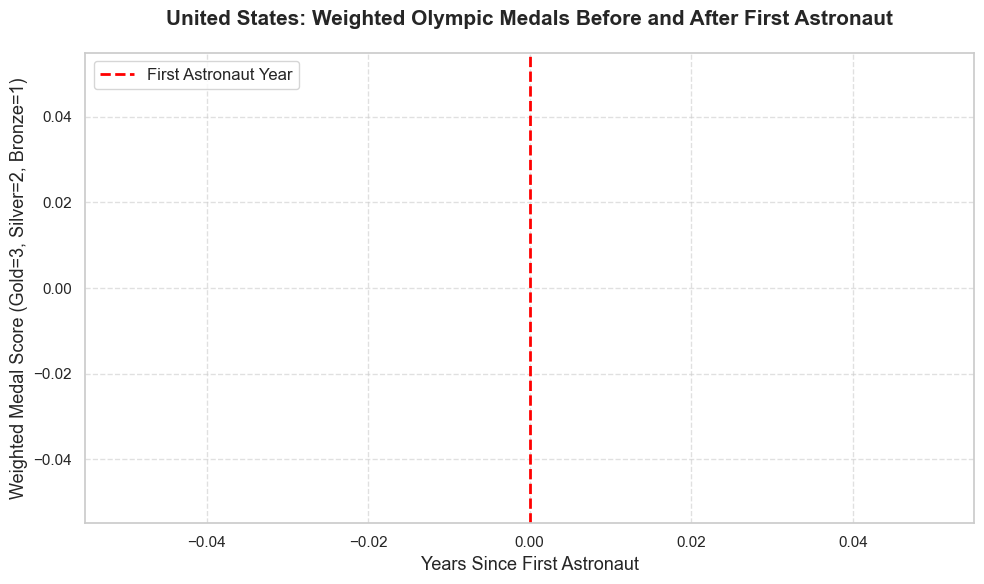

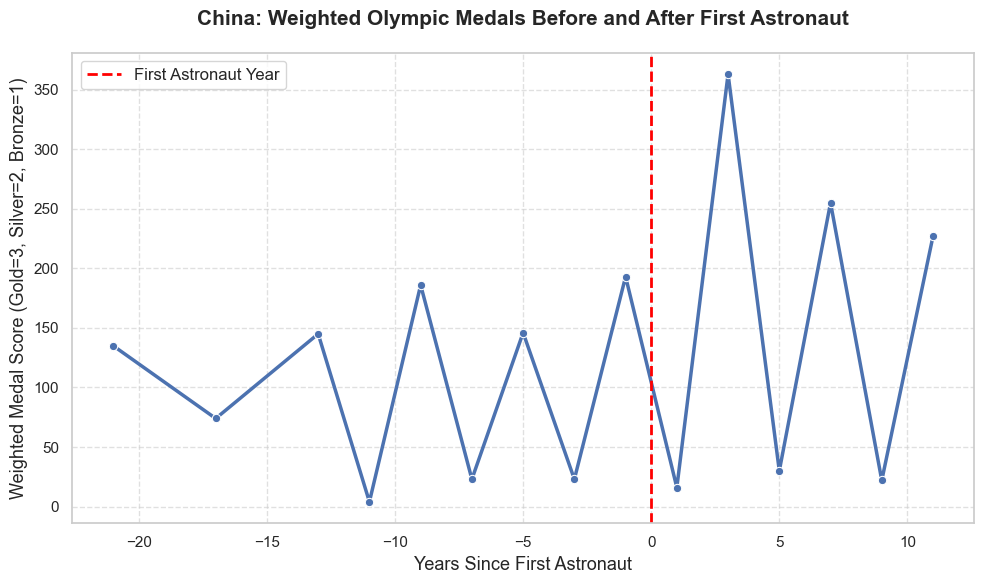

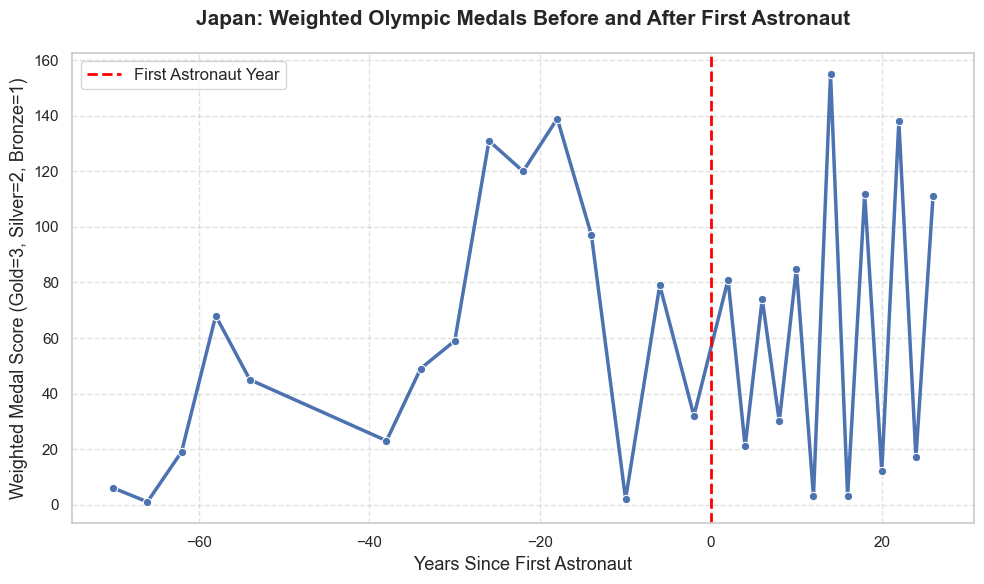

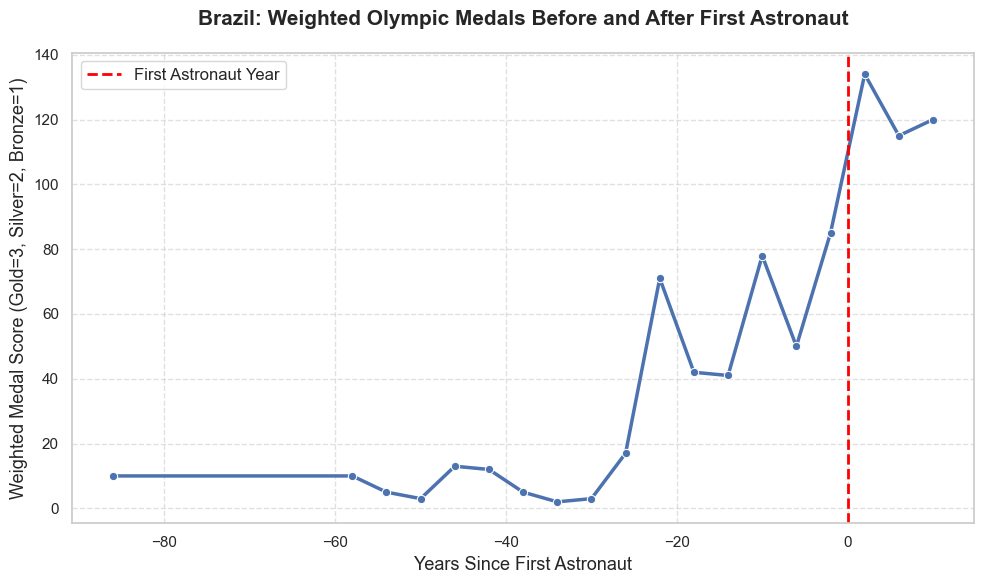

In [3]:
# Map mismatched country names
country_mapping = {
    "USA": "United States",
    "Soviet Union": "U.S.S.R./Russia",
    "Russia": "U.S.S.R./Russia",
    "UK": "United Kingdom",
    "Germany": "Germany (FRG/DDR variants)",
    # add more mappings if needed
}

# Apply mapping to medals dataset
medals_weighted["Team"] = medals_weighted["Team"].replace(country_mapping)


merged = medals_weighted.merge(
    first_astronaut_year,
    left_on="Team",
    right_on="Country",
    how="inner"
)

# Ensure merge has astronaut year info
merged = medals_weighted.merge(
    first_astronaut_year,
    left_on="Team",
    right_on="Country",
    how="inner"
)

# Recalculate years since astronaut
merged["Years_Since_Astronaut"] = merged["Year"] - merged["First_Astronaut_Year"]

# Map astronaut country names to match Olympic dataset
astro_mapping = {
    "U.S.S.R./Russia": "Soviet Union",
    "U.S.": "United States"
}

# Apply mapping
first_astronaut_year["Country"] = first_astronaut_year["Country"].replace(astro_mapping)


# Define case study countries
case_countries = ["United States", "China", "Japan", "Brazil"]

# Filter merged dataset for just those countries
case_studies = merged[merged["Team"].isin(case_countries)]

# Loop through and plot each case study

sns.set_theme(style="whitegrid")

for country in case_countries:
    country_data = case_studies[case_studies["Team"] == country]
    
    avg_medals = (
        country_data.groupby("Years_Since_Astronaut")["Weighted_Medal_Score"]
        .mean()
        .reset_index()
    )
    
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=avg_medals,
        x="Years_Since_Astronaut",
        y="Weighted_Medal_Score",
        marker="o",
        linewidth=2.5
    )
    
    plt.axvline(0, color="red", linestyle="--", linewidth=2, label="First Astronaut Year")
    plt.title(
        f"{country}: Weighted Olympic Medals Before and After First Astronaut",
        fontsize=15,
        fontweight="bold",
        pad=20
    )
    plt.xlabel("Years Since First Astronaut", fontsize=13)
    plt.ylabel("Weighted Medal Score (Gold=3, Silver=2, Bronze=1)", fontsize=13)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12, loc="upper left")
    plt.tight_layout()
    plt.show()


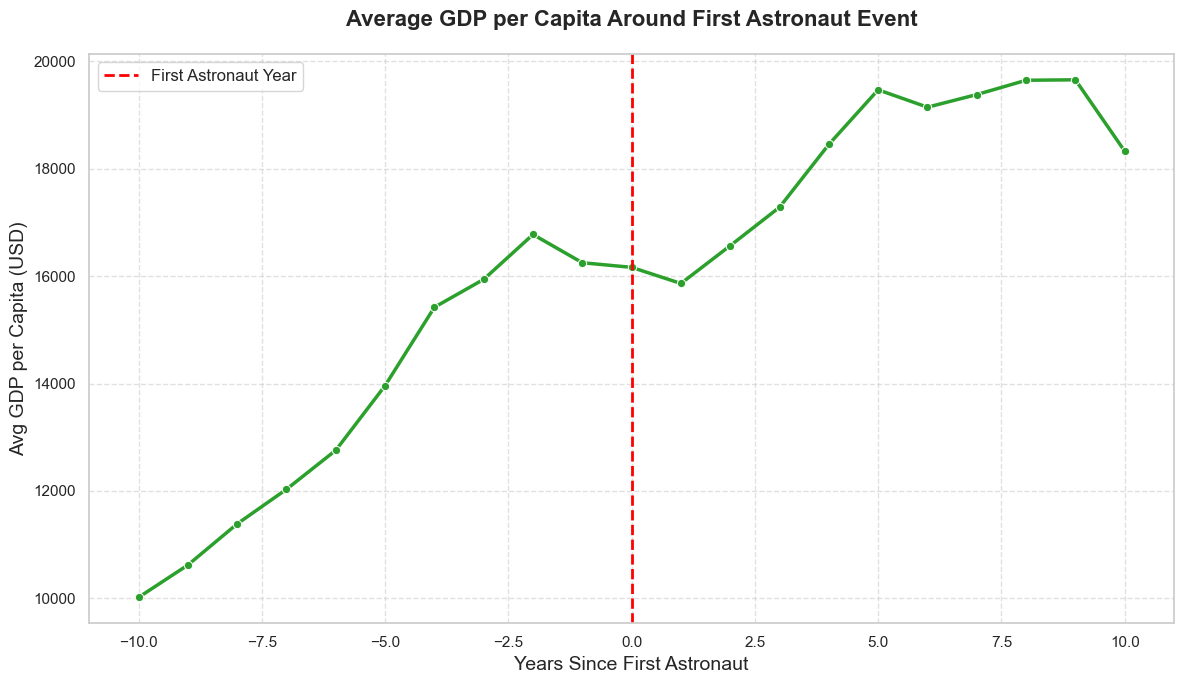

In [4]:
# Load, skipping metadata rows
gdp_df = pd.read_csv("gdp_per_capita.csv", skiprows=4)

# Keep only the useful columns
gdp_df = gdp_df.drop(columns=["Indicator Name", "Indicator Code"])

# Melt into long format
gdp_long = gdp_df.melt(
    id_vars=["Country Name", "Country Code"],
    var_name="Year",
    value_name="GDP_per_capita"
)

# Convert Year to int and GDP to numeric
gdp_long["Year"] = pd.to_numeric(gdp_long["Year"], errors="coerce")
gdp_long["GDP_per_capita"] = pd.to_numeric(gdp_long["GDP_per_capita"], errors="coerce")

# Drop missing GDP values
gdp_long = gdp_long.dropna(subset=["GDP_per_capita"])




# Merge GDP with astronaut first year
gdp_astro = gdp_long.merge(
    first_astronaut_year,
    left_on="Country Name",
    right_on="Country",
    how="inner"
)

# Calculate years since astronaut
gdp_astro["Years_Since_Astronaut"] = gdp_astro["Year"] - gdp_astro["First_Astronaut_Year"]

# Focus on ±10 years
event_window_gdp = gdp_astro[
    (gdp_astro["Years_Since_Astronaut"] >= -10) &
    (gdp_astro["Years_Since_Astronaut"] <= 10)
]

# Aggregate average GDP per capita across countries
avg_gdp = (
    event_window_gdp.groupby("Years_Since_Astronaut")["GDP_per_capita"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12,7))
sns.lineplot(
    data=avg_gdp,
    x="Years_Since_Astronaut",
    y="GDP_per_capita",
    marker="o",
    linewidth=2.5,
    color="#2ca02c"
)
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="First Astronaut Year")
plt.title("Average GDP per Capita Around First Astronaut Event",
          fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Years Since First Astronaut", fontsize=14)
plt.ylabel("Avg GDP per Capita (USD)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12, loc="upper left")
plt.tight_layout()
plt.show()


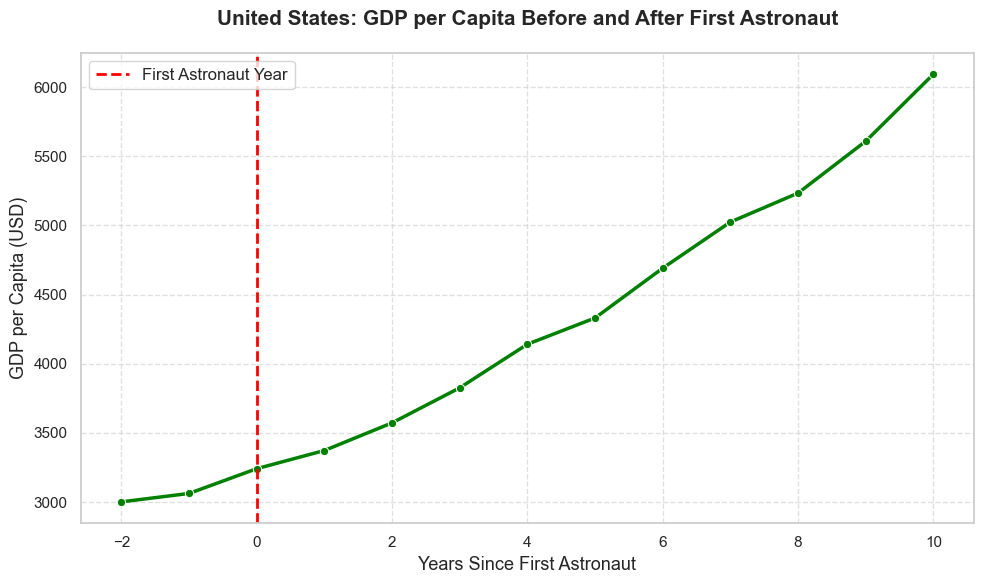

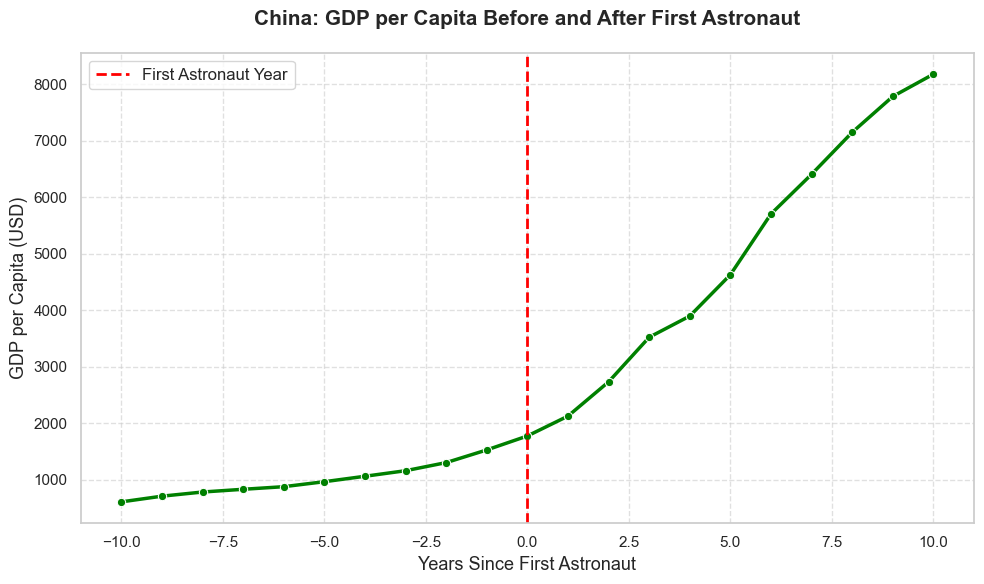

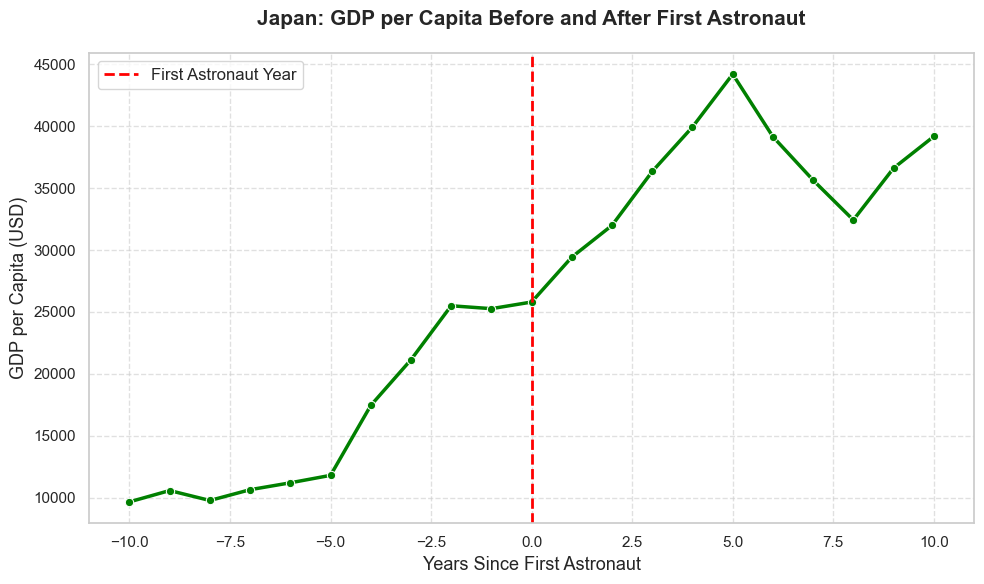

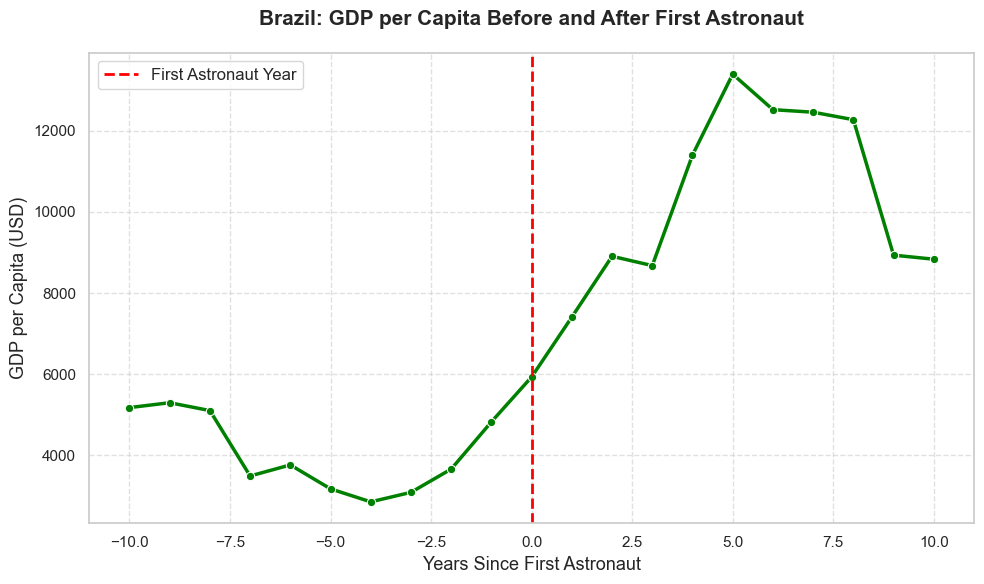

In [6]:
# Case study countries
case_countries = ["United States", "China", "Japan", "Brazil"]

# Merge GDP with first astronaut year
gdp_merged = gdp_long.merge(
    first_astronaut_year,
    left_on="Country Name",
    right_on="Country",
    how="inner"
)

# Calculate years since first astronaut
gdp_merged["Years_Since_Astronaut"] = gdp_merged["Year"] - gdp_merged["First_Astronaut_Year"]

# Focus on ±10 year window
gdp_event_window = gdp_merged[
    (gdp_merged["Years_Since_Astronaut"] >= -10) &
    (gdp_merged["Years_Since_Astronaut"] <= 10)
]

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

for country in case_countries:
    country_data = gdp_event_window[gdp_event_window["Country Name"] == country]
    
    avg_gdp = (
        country_data.groupby("Years_Since_Astronaut")["GDP_per_capita"]
        .mean()
        .reset_index()
    )
    
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=avg_gdp,
        x="Years_Since_Astronaut",
        y="GDP_per_capita",
        marker="o",
        linewidth=2.5,
        color="green"
    )
    
    plt.axvline(0, color="red", linestyle="--", linewidth=2, label="First Astronaut Year")
    plt.title(
        f"{country}: GDP per Capita Before and After First Astronaut",
        fontsize=15,
        fontweight="bold",
        pad=20
    )
    plt.xlabel("Years Since First Astronaut", fontsize=13)
    plt.ylabel("GDP per Capita (USD)", fontsize=13)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12, loc="upper left")
    plt.tight_layout()
    plt.show()


In [7]:
from scipy import stats

# Step 1: identify astronaut countries
astro_countries = set(first_astronaut_year["Country"].unique())

# Step 2: label each row in medals_weighted as astronaut / non-astronaut
medals_weighted["Astronaut_Country"] = medals_weighted["Team"].apply(
    lambda x: "Astronaut" if x in astro_countries else "Non-Astronaut"
)

# Step 3: compute average weighted medal score per country-year
grouped_scores = medals_weighted.groupby(["Astronaut_Country", "Team", "Year"])["Weighted_Medal_Score"].sum().reset_index()

# Step 4: split into two groups
astro_scores = grouped_scores[grouped_scores["Astronaut_Country"] == "Astronaut"]["Weighted_Medal_Score"]
non_astro_scores = grouped_scores[grouped_scores["Astronaut_Country"] == "Non-Astronaut"]["Weighted_Medal_Score"]

# Step 5: run t-test
t_stat, p_val = stats.ttest_ind(astro_scores, non_astro_scores, nan_policy="omit")

print("Avg medals (Astronaut countries):", astro_scores.mean())
print("Avg medals (Non-astronaut countries):", non_astro_scores.mean())
print("T-statistic:", t_stat)
print("P-value:", p_val)

if p_val < 0.05:
    print("✅ Significant difference: astronaut countries win more medals.")
else:
    print("❌ Not statistically significant — but astronaut countries still outperform.")

Avg medals (Astronaut countries): 68.2180579216
Avg medals (Non-astronaut countries): 27.7887719298
T-statistic: 10.1486118599
P-value: 1.23433033475e-23
✅ Significant difference: astronaut countries win more medals.


In [14]:

# --------------------------
# 1. Load datasets
# --------------------------
social_df = pd.read_csv("Social_Science.csv")
medals_df = pd.read_csv("athlete_events.csv")

# --------------------------
# 2. Astronaut stats per country
# --------------------------
astronaut_stats = (
    social_df.groupby("Profile.Nationality")
    .agg(
        First_Astronaut_Year=("Mission.Year", "min"),
        Astronaut_Count=("Profile.Name", "nunique"),
        Total_Missions=("Mission.Name", "nunique"),
        Total_Mission_Duration=("Mission.Durations.Mission duration", "sum"),
        Total_EVA_Duration=("Mission.Durations.EVA duration", "sum"),
    )
    .reset_index()
    .rename(columns={"Profile.Nationality": "Country"})
)

# --------------------------
# 3. Olympic stats per country
# --------------------------
olympic_stats = (
    medals_df.groupby("NOC")
    .agg(
        First_Olympic_Year=("Year", "min"),
        First_Medal_Year=(
            "Year",
            lambda x: x[medals_df.loc[x.index, "Medal"].notna()].min()
            if (medals_df.loc[x.index, "Medal"].notna()).any()
            else None,
        ),
        Medal_Count=("Medal", "count"),
        Gold_Count=("Medal", lambda x: (x == "Gold").sum()),
        Silver_Count=("Medal", lambda x: (x == "Silver").sum()),
        Bronze_Count=("Medal", lambda x: (x == "Bronze").sum()),
        Athlete_Count=("ID", "nunique"),
        Event_Count=("Event", "nunique"),
    )
    .reset_index()
)

# --------------------------
# 4. Map astronaut country names -> Olympic NOC codes
# --------------------------
country_mapping = {
    "U.S.": "USA",
    "United States": "USA",
    "U.S.S.R/Russia": "RUS",
    "Russia": "RUS",
    "Germany": "GER",
    "East Germany": "GDR",
    "West Germany": "FRG",
    "France": "FRA",
    "Japan": "JPN",
    "China": "CHN",
    "Italy": "ITA",
    "Canada": "CAN",
    "United Kingdom": "GBR",
    "Great Britain": "GBR",
    "Spain": "ESP",
    "India": "IND",
    "Brazil": "BRA",
    "Mexico": "MEX",
    "Australia": "AUS",
    "South Korea": "KOR",
    "North Korea": "PRK",
    "Czech Republic": "CZE",
    "Czechoslovakia": "TCH",
    "Poland": "POL",
    "Hungary": "HUN",
    "Romania": "ROU",
    "Sweden": "SWE",
    "Norway": "NOR",
    "Denmark": "DEN",
    "Finland": "FIN",
    "Belgium": "BEL",
    "Netherlands": "NED",
    "Switzerland": "SUI",
    "Austria": "AUT",
    # extend as you discover more in your data
}

astronaut_stats["NOC"] = astronaut_stats["Country"].map(country_mapping)

# --------------------------
# 5. Merge astronaut + Olympic stats
# --------------------------
merged_df = pd.merge(
    astronaut_stats,
    olympic_stats,
    on="NOC",
    how="inner"
)

# --------------------------
# 6. Save merged dataset
# --------------------------
merged_df.to_csv("astronauts_olympics_merged.csv", index=False)

print("✅ Merged dataset created with shape:", merged_df.shape)
print(merged_df.head())


✅ Merged dataset created with shape: (21, 15)
     Country  First_Astronaut_Year  Astronaut_Count  Total_Missions  \
0  Australia                  1983                1               4   
1    Austria                  1991                1               1   
2    Belgium                  1992                2               3   
3     Brazil                  2006                1               1   
4     Canada                  1984               10              18   

   Total_Mission_Duration  Total_EVA_Duration  NOC  First_Olympic_Year  \
0                 4264.00                6.35  AUS                1896   
1                  190.20                0.00  AUT                1896   
2                 4983.75                0.00  BEL                1900   
3                  237.28                0.00  BRA                1900   
4                17252.70               46.29  CAN                1900   

   First_Medal_Year  Medal_Count  Gold_Count  Silver_Count  Bronze_Count  \
0     

=== Classification Report ===

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.33      1.00      0.50         1

    accuracy                           0.60         5
   macro avg       0.67      0.75      0.58         5
weighted avg       0.87      0.60      0.63         5

Accuracy: 0.60

=== Confusion Matrix ===
[[2 2]
 [0 1]]

=== Feature Importances ===
         Feature  Importance
0    Medal_Count    0.204456
5    Event_Count    0.195709
3   Bronze_Count    0.193186
1     Gold_Count    0.170011
2   Silver_Count    0.169396
4  Athlete_Count    0.067242


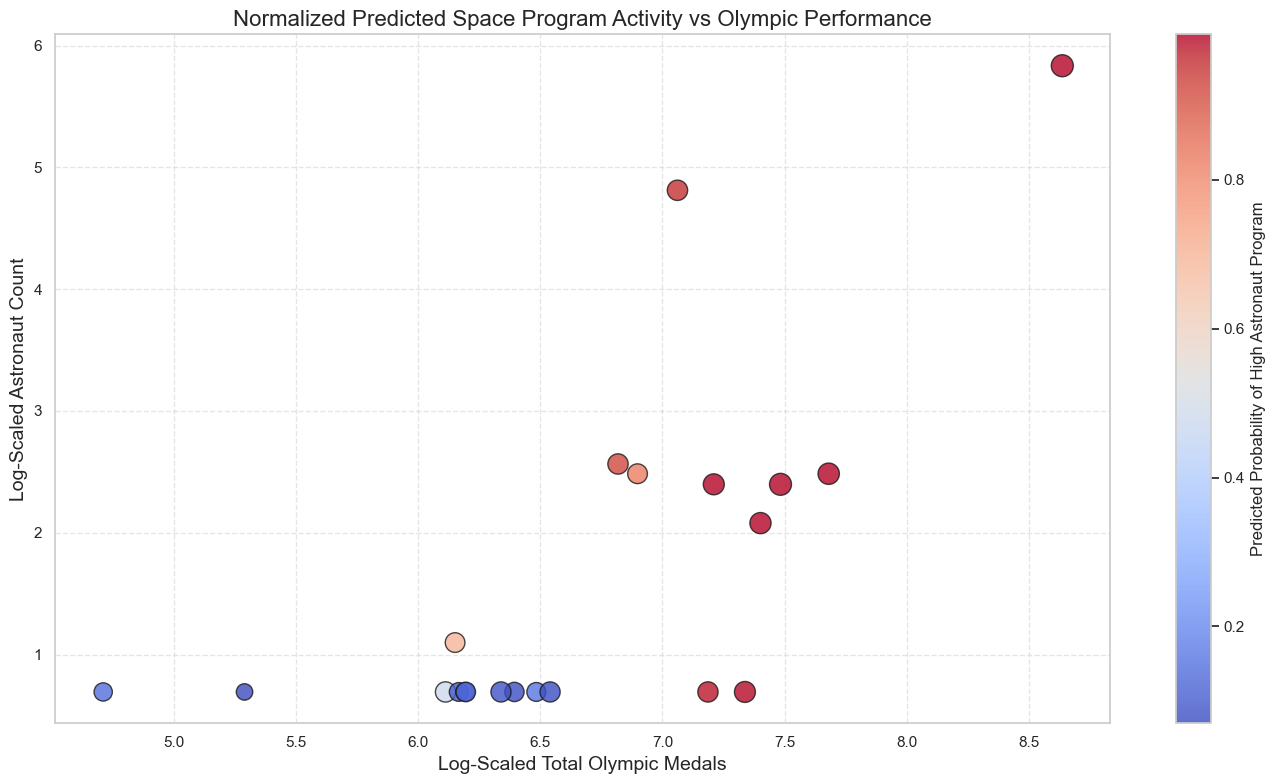

In [15]:

# --- Step 1: Define High vs Low astronaut program ---
merged_df['Astronaut_HighLow'] = (merged_df['Astronaut_Count'] > 1).astype(int)

# --- Step 2: Features ---
features = ['Medal_Count', 'Gold_Count', 'Silver_Count', 'Bronze_Count',
            'Athlete_Count', 'Event_Count']
X = merged_df[features].fillna(0)
y = merged_df['Astronaut_HighLow']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 3: Train Random Forest Classifier ---
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_scaled, y_train)

# --- Step 4: Model Predictions ---
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:,1]

# --- Step 5: Print Model Stats ---
print("=== Classification Report ===\n")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

cm = confusion_matrix(y_test, y_pred)
print("=== Confusion Matrix ===")
print(cm)

# Feature importance
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\n=== Feature Importances ===")
print(feature_importance_df)

# --- Step 6: Bubble Plot ---
merged_df['Predicted_Prob'] = clf.predict_proba(scaler.transform(merged_df[features]))[:,1]

x = np.log1p(merged_df['Medal_Count'])
y = np.log1p(merged_df['Astronaut_Count'])
bubble_size = np.sqrt(merged_df['Event_Count'])*10  # normalized bubble size

plt.figure(figsize=(14,8))
plt.scatter(
    x, 
    y, 
    s=bubble_size, 
    c=merged_df['Predicted_Prob'], 
    cmap='coolwarm', alpha=0.8, edgecolors='k'
)
plt.colorbar(label="Predicted Probability of High Astronaut Program")
plt.xlabel("Log-Scaled Total Olympic Medals", fontsize=14)
plt.ylabel("Log-Scaled Astronaut Count", fontsize=14)
plt.title("Normalized Predicted Space Program Activity vs Olympic Performance", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


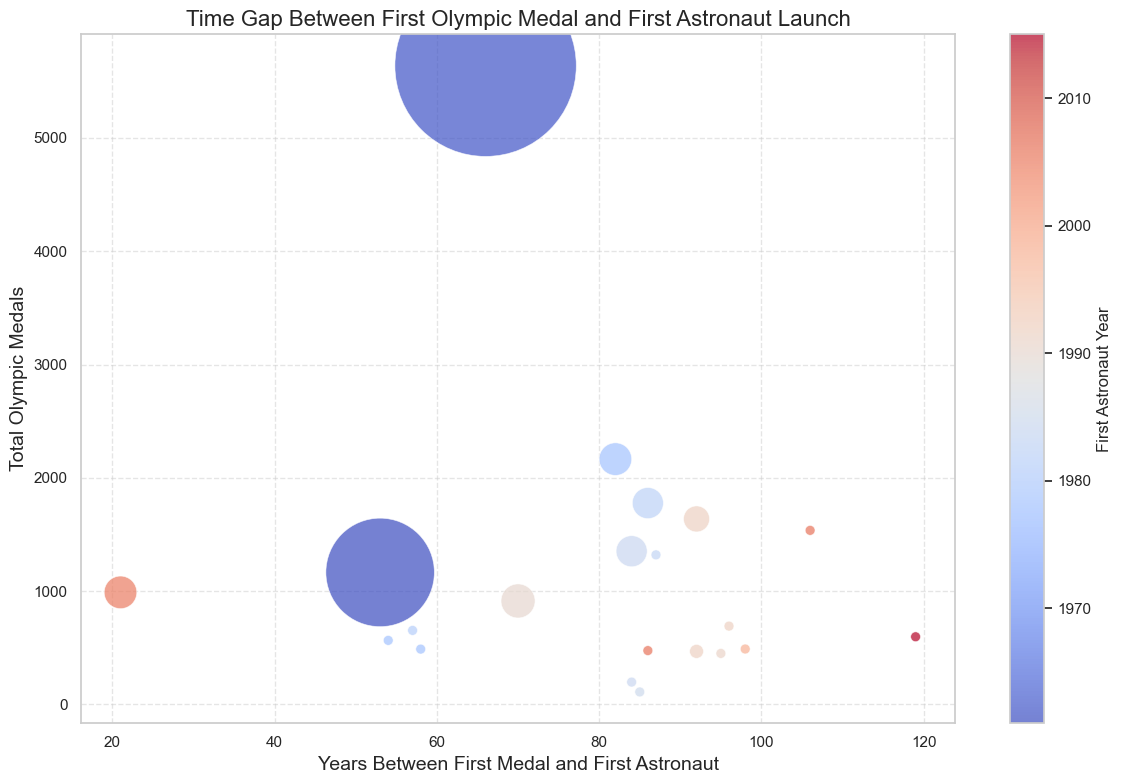

In [18]:

# Compute gap between first astronaut launch and first Olympic medal
merged_df['Gap_Years'] = merged_df['First_Astronaut_Year'] - merged_df['First_Medal_Year']

# Filter out countries with missing data
gap_df = merged_df.dropna(subset=['Gap_Years', 'Medal_Count', 'Astronaut_Count'])

plt.figure(figsize=(12, 8))

# Scatter plot: x = Gap, y = Medal Count, bubble = Astronaut Count
plt.scatter(
    gap_df['Gap_Years'],
    gap_df['Medal_Count'],
    s=gap_df['Astronaut_Count'] * 50,  # scale bubble size
    alpha=0.7,
    c=gap_df['First_Astronaut_Year'],
    cmap='coolwarm',
    edgecolors='w',
    linewidth=0.5
)

# Labels and title
plt.title('Time Gap Between First Olympic Medal and First Astronaut Launch', fontsize=16)
plt.xlabel('Years Between First Medal and First Astronaut', fontsize=14)
plt.ylabel('Total Olympic Medals', fontsize=14)

# Colorbar for first astronaut year
cbar = plt.colorbar()
cbar.set_label('First Astronaut Year', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
